In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/santander-customer-transaction-prediction/sample_submission.csv
/kaggle/input/santander-customer-transaction-prediction/test.csv
/kaggle/input/santander-customer-transaction-prediction/train.csv


In [2]:
import gc
import os
import time
import math
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold

from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold

# Importing all models

# Classification
from sklearn.linear_model import LogisticRegression, ElasticNet, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, \
    RandomForestClassifier, VotingClassifier


import lightgbm as lgb
import xgboost as xgb
import catboost as cat
from catboost import Pool, CatBoostClassifier

import warnings
print(os.listdir("../input"))
warnings.simplefilter('ignore')

['santander-customer-transaction-prediction']


In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [7]:
train = import_data("/kaggle/input/santander-customer-transaction-prediction/train.csv")
test = import_data("/kaggle/input/santander-customer-transaction-prediction/test.csv")
sub = import_data("/kaggle/input/santander-customer-transaction-prediction/sample_submission.csv")

print("\n\nTrain Size : \t{}\nTest Size : \t{}".format(train.shape, test.shape))

Memory usage of dataframe is 308.23 MB
Memory usage after optimization is: 83.77 MB
Decreased by 72.8%
Memory usage of dataframe is 306.70 MB
Memory usage after optimization is: 83.58 MB
Decreased by 72.7%
Memory usage of dataframe is 3.05 MB
Memory usage after optimization is: 7.48 MB
Decreased by -145.1%


Train Size : 	(200000, 202)
Test Size : 	(200000, 201)


In [8]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.921875,-6.785156,11.906250,5.093750,11.460938,-9.281250,5.117188,18.625000,...,4.433594,3.964844,3.136719,1.691406,18.515625,-2.398438,7.878906,8.562500,12.781250,-1.091797
1,train_1,0,11.500000,-4.148438,13.859375,5.390625,12.359375,7.042969,5.621094,16.531250,...,7.640625,7.722656,2.583984,10.953125,15.429688,2.033203,8.125000,8.789062,18.359375,1.952148
2,train_2,0,8.609375,-2.746094,12.078125,7.894531,10.585938,-9.085938,6.941406,14.617188,...,2.906250,9.789062,1.669922,1.685547,21.609375,3.142578,-6.519531,8.265625,14.718750,0.396484
3,train_3,0,11.062500,-2.152344,8.953125,7.195312,12.585938,-1.835938,5.843750,14.921875,...,4.464844,4.742188,0.717773,1.421875,23.031250,-1.270508,-2.927734,10.289062,17.968750,-9.000000
4,train_4,0,9.835938,-1.483398,12.875000,6.636719,12.273438,2.449219,5.941406,19.250000,...,-1.490234,9.523438,-0.150757,9.195312,13.289062,-1.511719,3.925781,9.500000,18.000000,-8.812500


In [9]:
def missing_values(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
                                                              "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

miss_train = missing_values(train)
miss_test = missing_values(test)

Your selected dataframe has 202 columns.
There are 0 columns that have missing values.
Your selected dataframe has 201 columns.
There are 0 columns that have missing values.


In [15]:
def univariate(df, col, vartype, hue=None):
    '''
    Univariate function will plot the graphs based on the parameters.
    df      : dataframe name
    col     : Column name
    vartype : variable type : continuos or categorical
                Continuos(0)   : Distribution, Violin & Boxplot will be plotted.
                Categorical(1) : Countplot will be plotted.
    hue     : It's only applicable for categorical analysis.

    Call: univariate(df=data,col='col',vartype=0)
    '''
    sns.set(style="darkgrid")

    if vartype == 0:
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))
        ax[0].set_title("Distribution Plot")
        sns.distplot(df[col], ax=ax[0])
        ax[1].set_title("Violin Plot")
        sns.violinplot(data=df, x=col, ax=ax[1], inner="quartile")
        ax[2].set_title("Box Plot")
        sns.boxplot(data=df, x=col, ax=ax[2], orient='v')

    if vartype == 1:
        temp = pd.Series(data=hue)
        print(len(temp.unique()))
        fig, ax = plt.subplots()
        width = len(df[col].unique()) + 6 + 4 * len(temp.unique())
        fig.set_size_inches(width, 7)
        ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, hue=hue)
        if len(temp.unique()) > 0:
            for p in ax.patches:
                if p.get_height() > 0:
                    ax.annotate('{:1.1f}%'.format((p.get_height() * 100) / float(len(loan_data))),
                                (p.get_x() + 0.05, p.get_height() + 20))
        else:
            for p in ax.patches:
                ax.annotate(p.get_height(), (p.get_x() + 0.32, p.get_height() + 20))
        del temp
    else:
        exit

    plt.show()

0


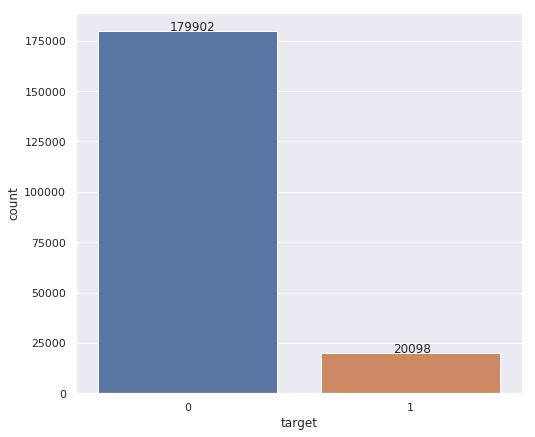

In [16]:
univariate(train, 'target', 1)

In [17]:
train['target'].value_counts(normalize=True)

0    0.89951
1    0.10049
Name: target, dtype: float64

In [18]:
target = 'target'
features = train.columns.tolist()
features.remove(target)
features.remove("ID_code")
print("Feature Length : {}".format(len(features)))

Feature Length : 200


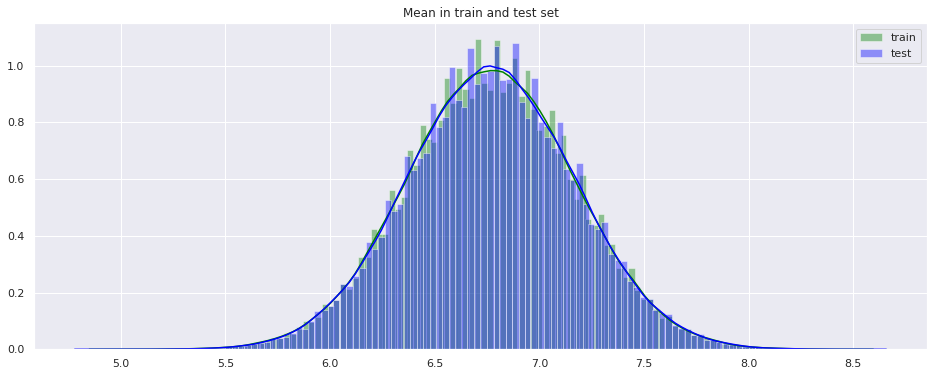

In [19]:
plt.figure(figsize=(16,6))
plt.title("Mean in train and test set")
sns.distplot(train[features].mean(axis=1), color="green", kde=True, bins=120, label='train')
sns.distplot(test[features].mean(axis=1), color="blue", kde=True, bins=120, label='test')
plt.legend()
plt.show()

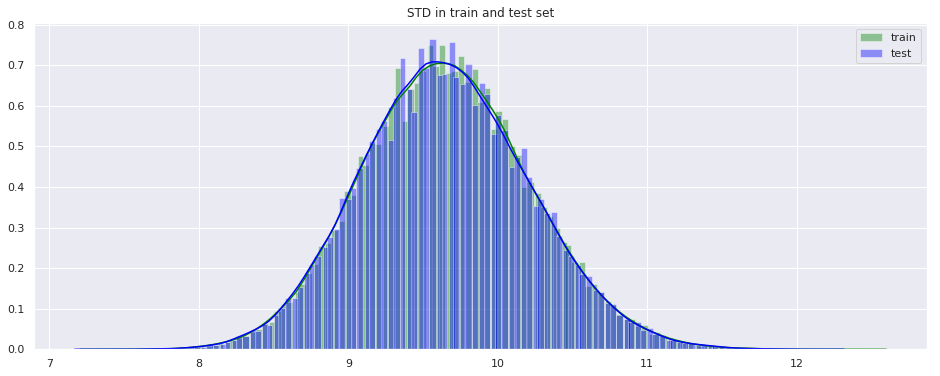

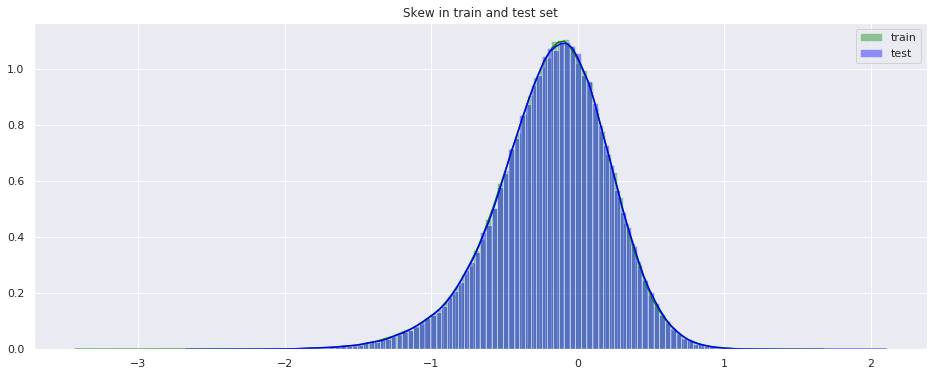

In [20]:
plt.figure(figsize=(16,6))
plt.title("STD in train and test set")
sns.distplot(train[features].std(axis=1), color="green", kde=True, bins=120, label='train')
sns.distplot(test[features].std(axis=1), color="blue", kde=True, bins=120, label='test')
plt.legend()
plt.show()
plt.figure(figsize=(16,6))
plt.title("Skew in train and test set")
sns.distplot(train[features].skew(axis=1), color="green", kde=True, bins=120, label='train')
sns.distplot(test[features].skew(axis=1), color="blue", kde=True, bins=120, label='test')
plt.legend()
plt.show()

In [21]:
# Skewness and Kurtosis
print("Skewness: %f" % train['target'].skew())
print("Kurtosis: %f" % train['target'].kurt())

Skewness: 2.657642
Kurtosis: 5.063112


Distributions of first 10 columns


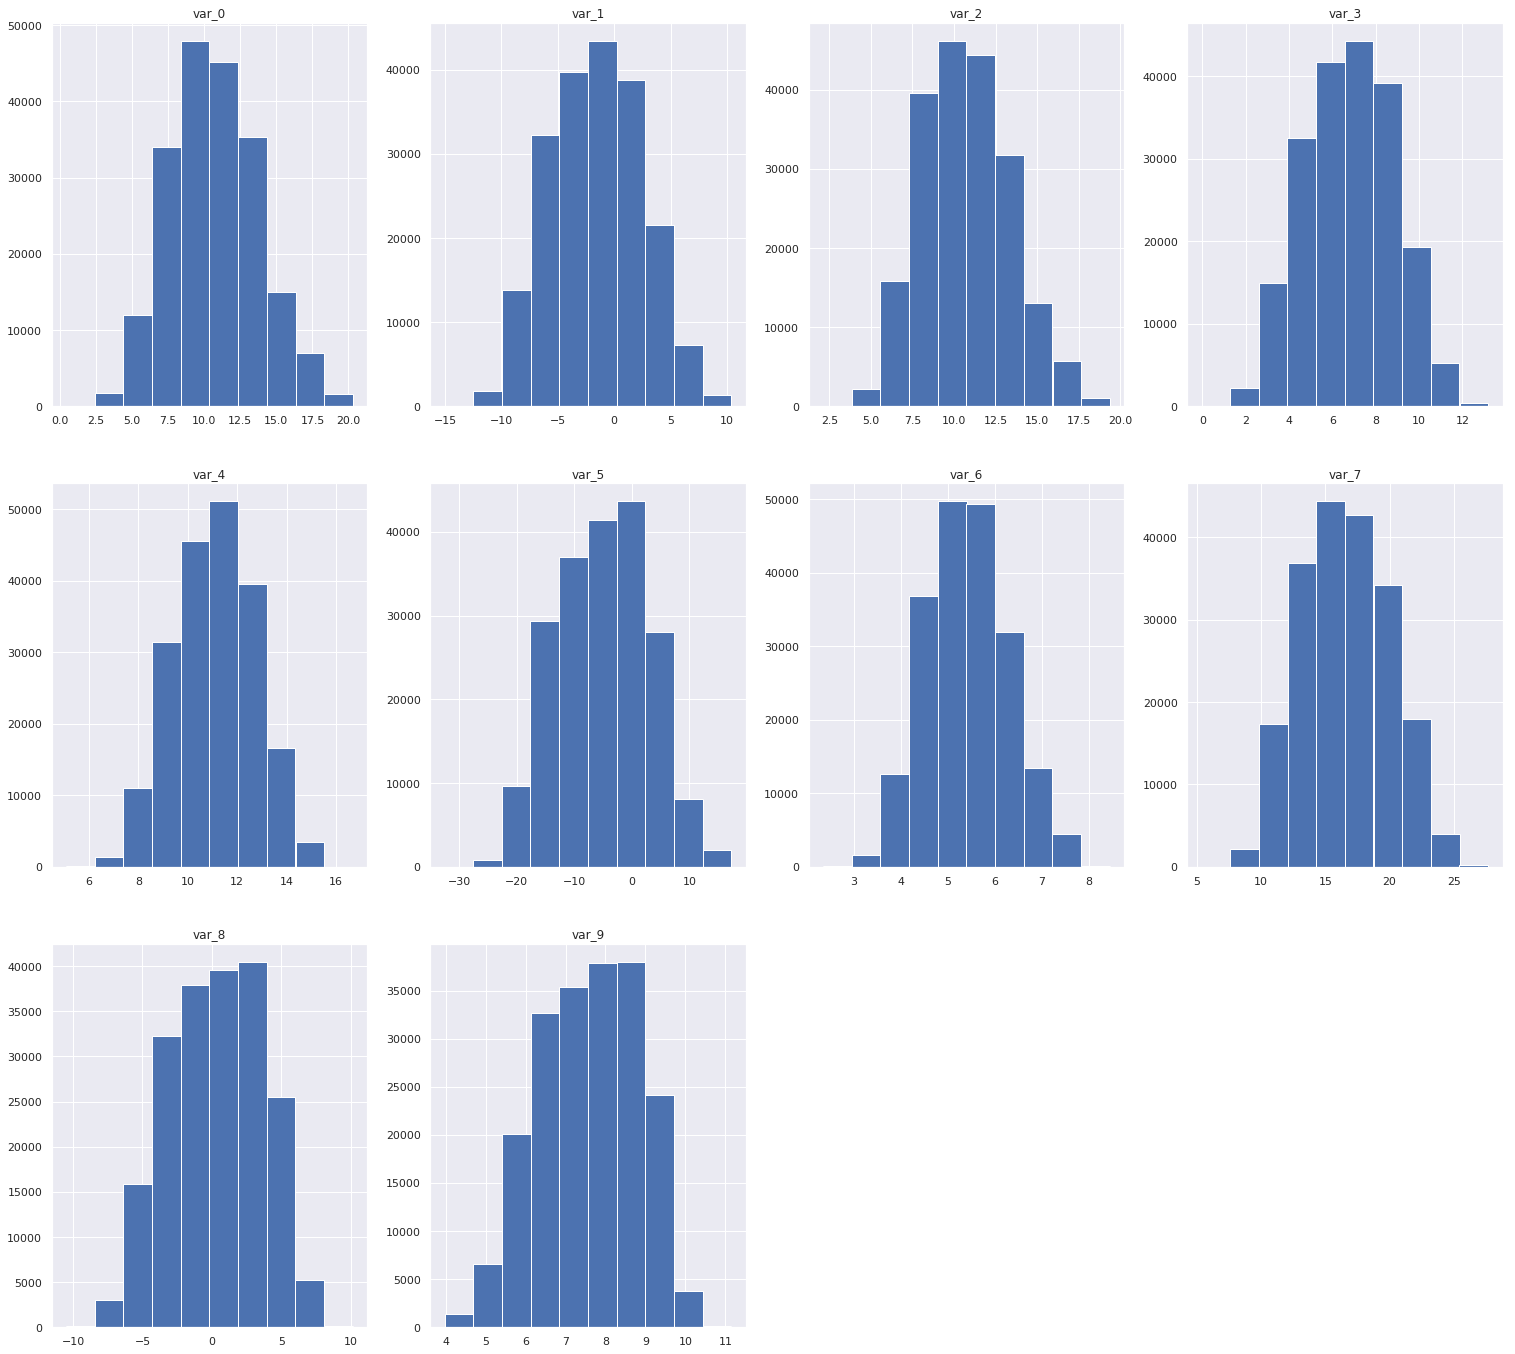

In [22]:
def plot_and_compare(data, num):
    print('Distributions of first {} columns'.format(num))
    plt.figure(figsize=(26, 24))
    for i, col in enumerate(list(data.columns)[2:num + 2]):
        plt.subplot(math.ceil(num/4), 4, i + 1)
        plt.hist(data[col])
        plt.title(col)
    plt.show()
plot_and_compare(train, 10)

Distributions of first 50 columns


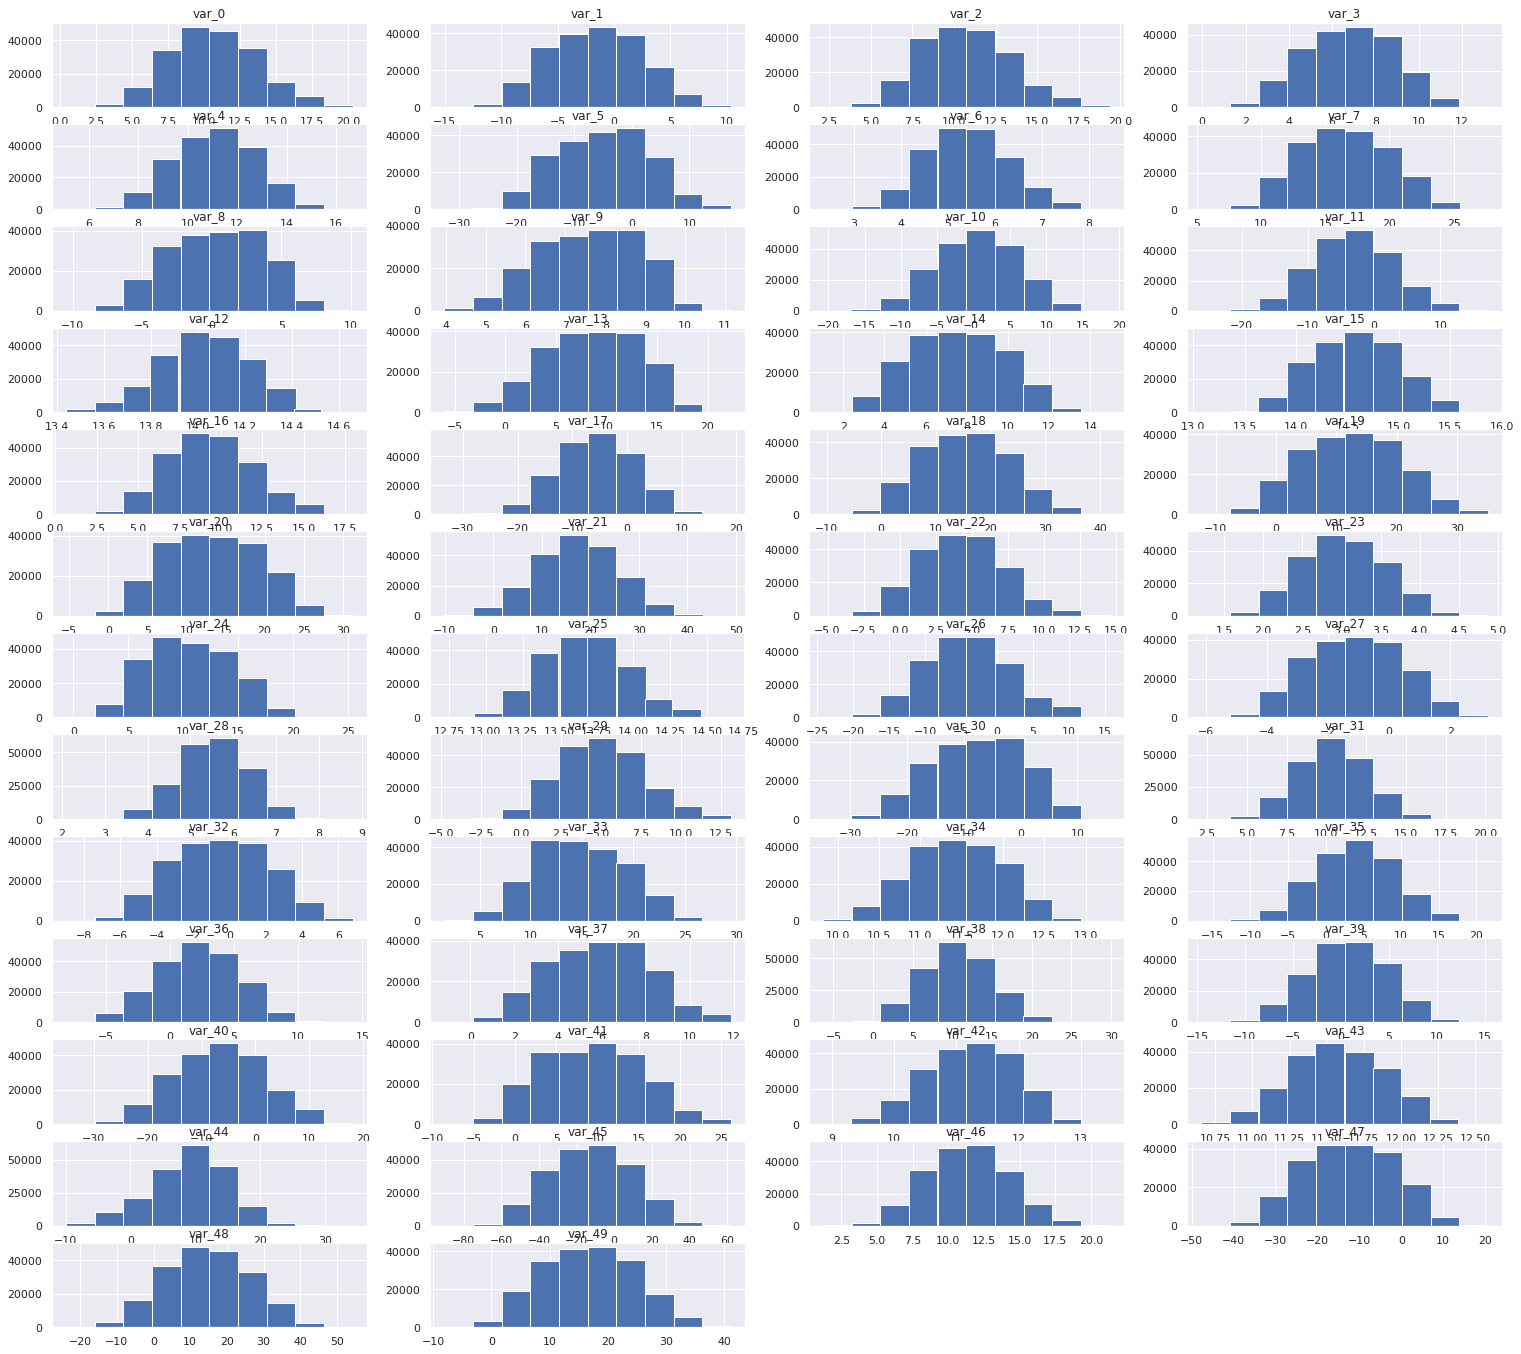

In [23]:
plot_and_compare(train, 50)

In [24]:
def plot_corr(data):
    data_correlation = data.corr()
    f, ax = plt.subplots(figsize=(25, 25))
    sns.heatmap(data_correlation,
                xticklabels=data_correlation.columns.values,
                yticklabels=data_correlation.columns.values, annot=True)
    plt.show()

In [25]:
tuniq = train.nunique().sort_values().reset_index()
tuniq.head()

,index,0
0,target,2
1,var_68,15
2,var_108,127
3,var_12,150
4,var_25,237


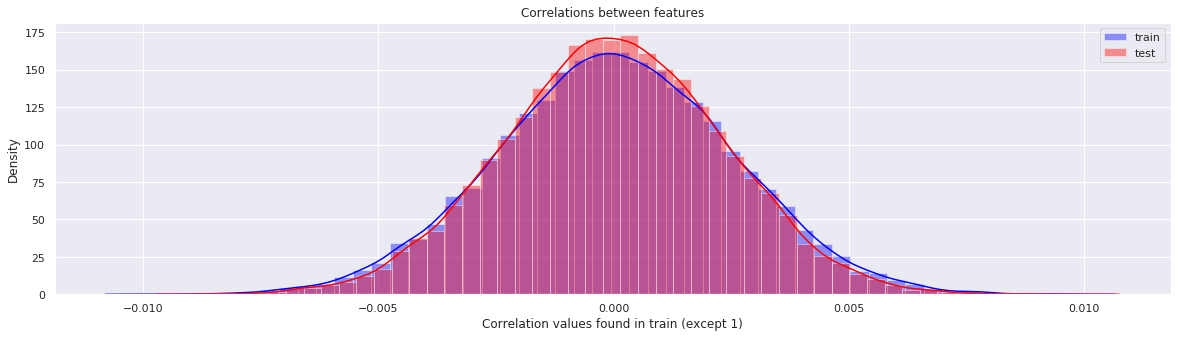

In [26]:
train_correlations = train.drop(["target"], axis=1).corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

test_correlations = test.corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Blue", label="train")
sns.distplot(test_correlations, color="Red", label="test")
plt.xlabel("Correlation values found in train (except 1)")
plt.ylabel("Density")
plt.title("Correlations between features"); 
plt.legend()

In [27]:
def baseliner_clas(train, feat, target, cv, metric):

    eval_dict = {}
    models = [lgb.LGBMClassifier()]
    # LogisticRegression(), SVC(), GaussianNB(), KNeighborsClassifier(), DecisionTreeClassifier(), ExtraTreeClassifier(), AdaBoostClassifier(), BaggingClassifier(),
    # RandomForestClassifier(), ExtraTreesClassifier(), GradientBoostingClassifier(), xgb.XGBClassifier(), cat.CatBoostClassifier(verbose=0)

    for model in models:
        model_name = str(model).split("(")[0]
        results = cross_val_score(model, train[feat], train[target], cv=cv,
                                  scoring=metric)
        print(model_name, results.mean(), results)
        eval_dict[model_name] = results.mean()

    return eval_dict

In [28]:
base_1 = baseliner_clas(train, features, target, 3, 'roc_auc')

LGBMClassifier 0.863698056662805 [0.86160664 0.86346855 0.86601898]


In [29]:
def lgb_model(train, feat, target):
    x_train, x_valid, y_train, y_valid = train_test_split(train[feat], train[target], test_size=0.2, random_state=13)

    train_set = lgb.Dataset(x_train, label=y_train)
    valid_set = lgb.Dataset(x_valid, label=y_valid)

    MAX_ROUNDS = 2000
    params = {
        "boosting": 'gbdt', # "dart",
        "learning_rate": 0.01,
        "nthread": -1,
        "seed": 13,
        "num_boost_round": MAX_ROUNDS,
        "objective": "binary",
        "metric": "auc",
    }

    model = lgb.train(
        params,
        train_set=train_set,
        valid_sets=[train_set, valid_set],
        early_stopping_rounds=50,
        verbose_eval=100
    )

    lgb.plot_importance(model, figsize=(24, 50))

    return model

Training until validation scores don't improve for 50 rounds.
[100]	training's auc: 0.808229	valid_1's auc: 0.783972
[200]	training's auc: 0.849473	valid_1's auc: 0.816763
[300]	training's auc: 0.872012	valid_1's auc: 0.833576
[400]	training's auc: 0.887753	valid_1's auc: 0.845329
[500]	training's auc: 0.899421	valid_1's auc: 0.85369
[600]	training's auc: 0.908498	valid_1's auc: 0.860118
[700]	training's auc: 0.916037	valid_1's auc: 0.865098
[800]	training's auc: 0.922215	valid_1's auc: 0.869045
[900]	training's auc: 0.927419	valid_1's auc: 0.872287
[1000]	training's auc: 0.932136	valid_1's auc: 0.87518
[1100]	training's auc: 0.936347	valid_1's auc: 0.877597
[1200]	training's auc: 0.940073	valid_1's auc: 0.879591
[1300]	training's auc: 0.943386	valid_1's auc: 0.881509
[1400]	training's auc: 0.946381	valid_1's auc: 0.883191
[1500]	training's auc: 0.949136	valid_1's auc: 0.884555
[1600]	training's auc: 0.951636	valid_1's auc: 0.885831
[1700]	training's auc: 0.954023	valid_1's auc: 0.8870

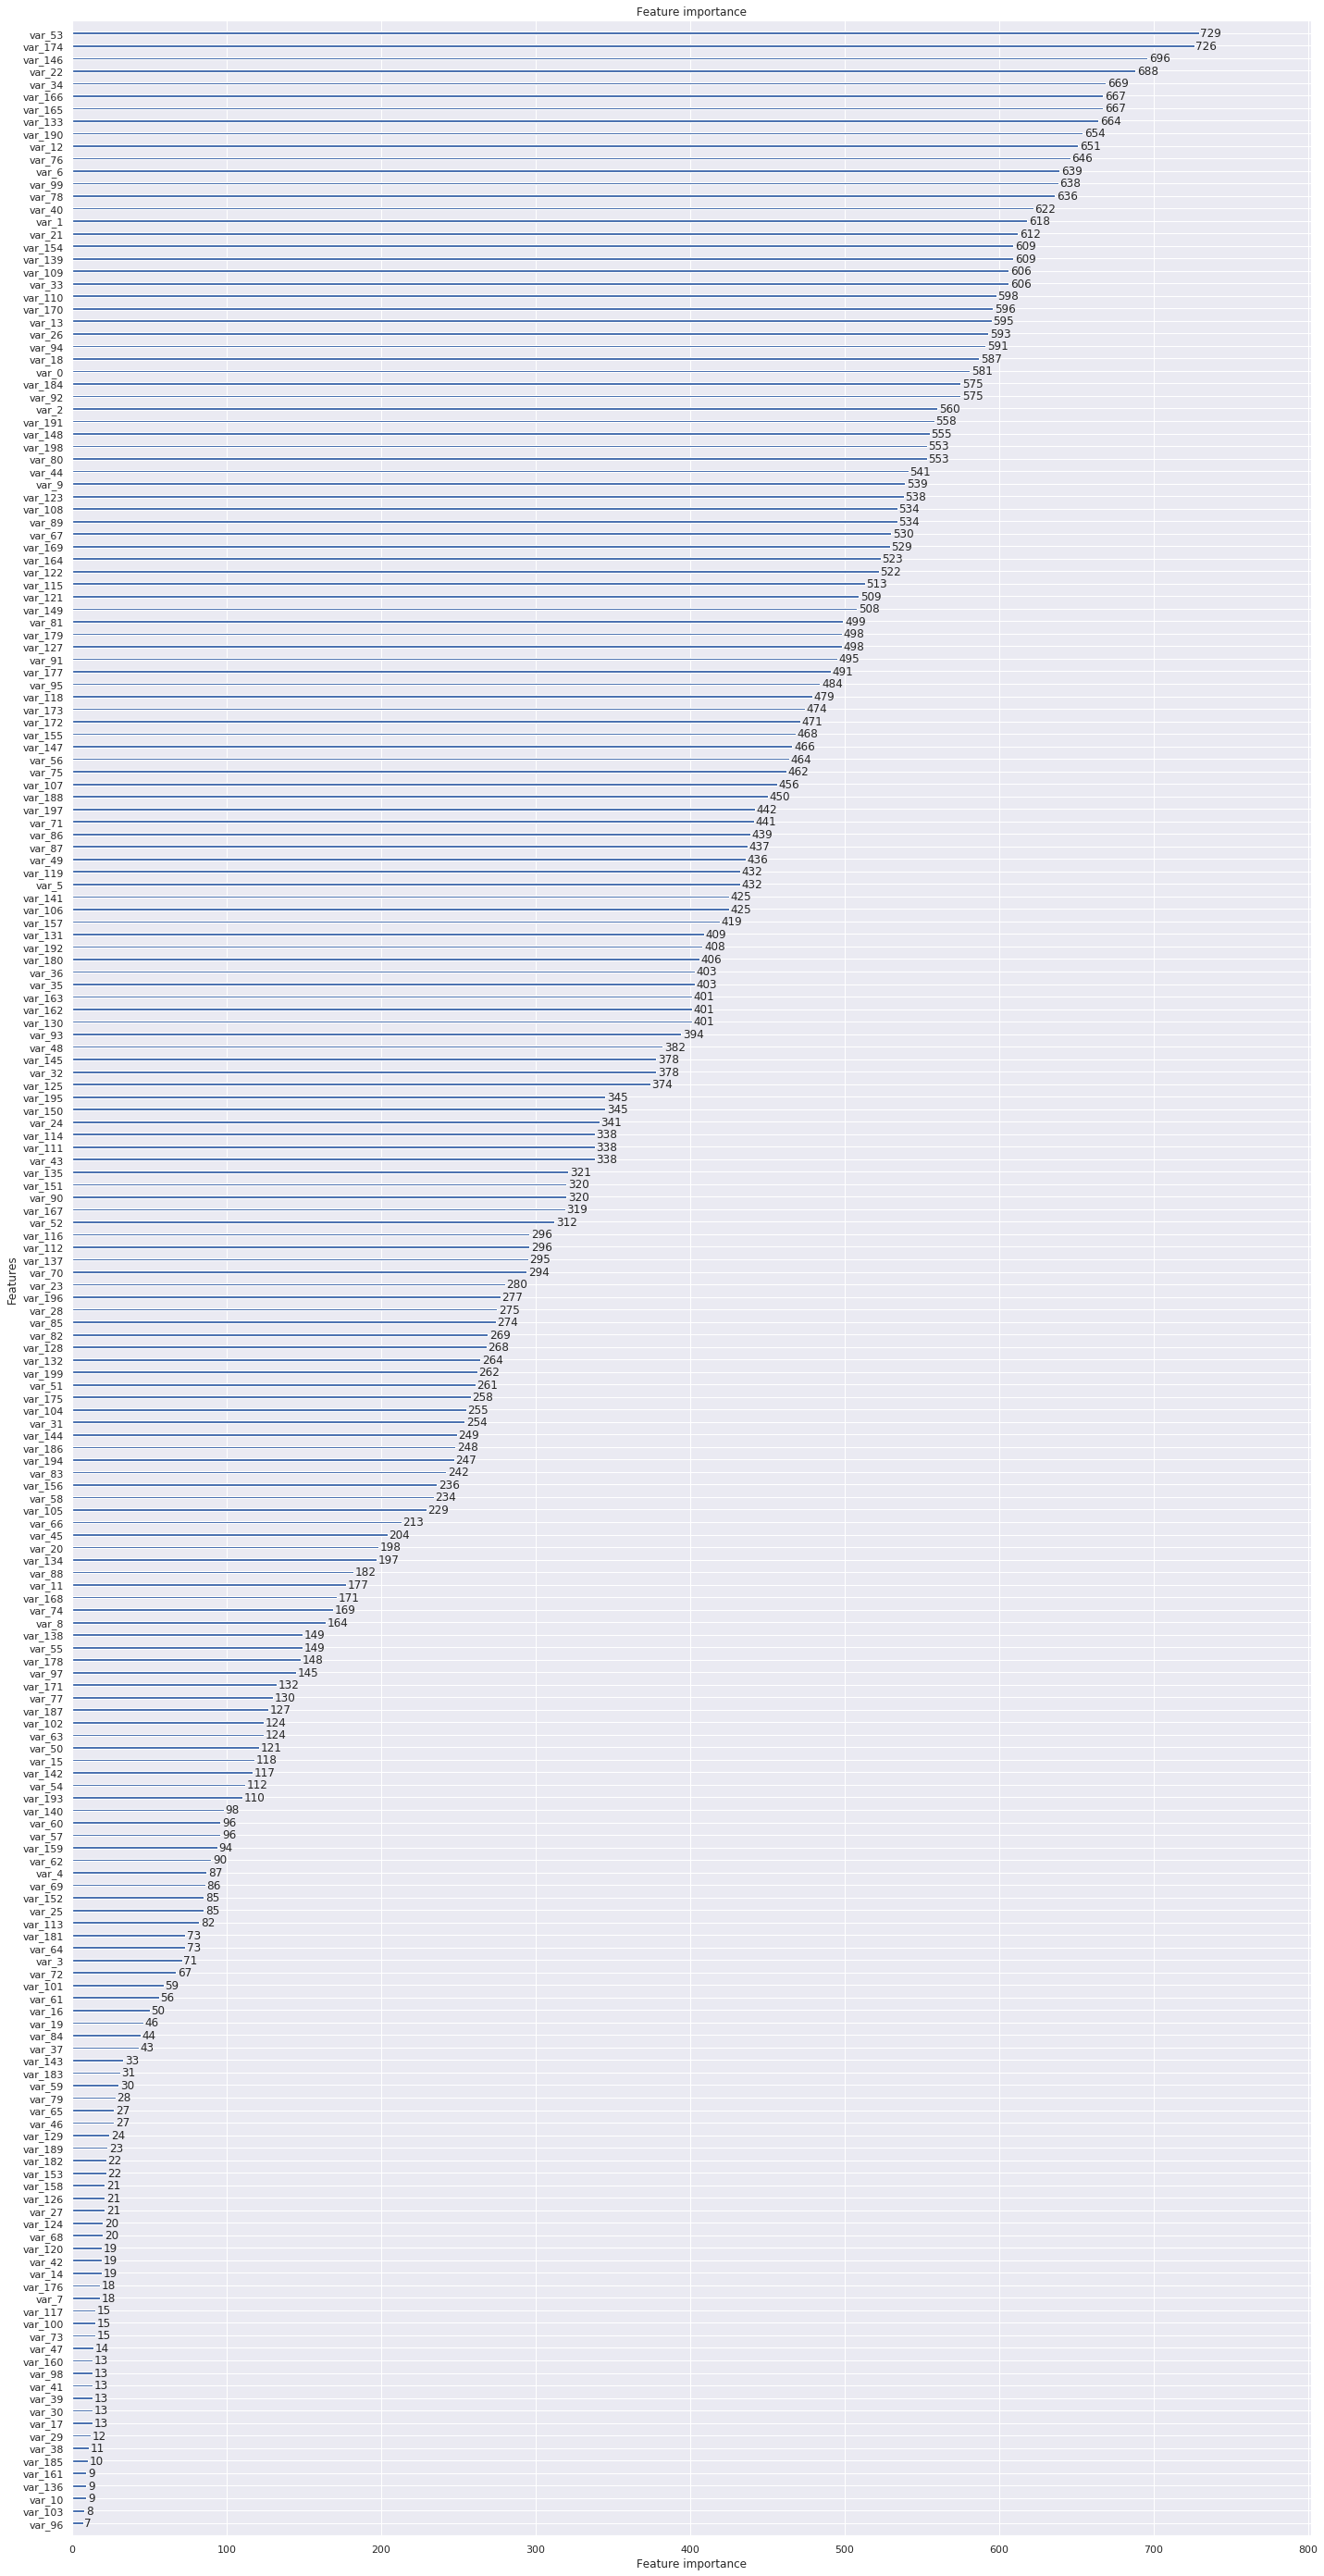

In [30]:
model = lgb_model(train, features, target)

In [31]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image as PImage
from sklearn.externals.six import StringIO

dtree = DecisionTreeClassifier(max_depth=4)
dtree.fit(train[features], train[target])

dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data, max_depth = 4, 
                     impurity = True, feature_names = features, 
                     class_names = ['0', '1'], rounded = True, filled= True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
PImage(graph.create_png())

ModuleNotFoundError: No module named 'pydotplus'

In [34]:
bayesian_tr_index, bayesian_val_index  = list(StratifiedKFold(n_splits=2, shuffle=True, random_state=1).split(train, train.target.values))[0]
print(len(bayesian_tr_index), len(bayesian_val_index))

100000 100000


In [35]:
# Function for LGB model creation for bayesian optimisation

def LGB_bayesian(
    num_leaves,  # int
    min_data_in_leaf,  # int
    learning_rate,
    min_sum_hessian_in_leaf,    # int  
    feature_fraction,
    lambda_l1,
    lambda_l2,
    min_gain_to_split,
    max_depth):
    
    # LightGBM expects next three parameters need to be integer. So we make them integer
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)

    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int

    param = {
        'num_leaves': num_leaves,
        'max_bin': 63,
        'min_data_in_leaf': min_data_in_leaf,
        'learning_rate': learning_rate,
        'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
        'bagging_fraction': 1.0,
        'bagging_freq': 5,
        'feature_fraction': feature_fraction,
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'min_gain_to_split': min_gain_to_split,
        'max_depth': max_depth,
        'save_binary': True, 
        'seed': 13,
        'feature_fraction_seed': 13,
        'bagging_seed': 13,
        'drop_seed': 13,
        'data_random_seed': 13,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,   

    }    
    
    
    xg_train = lgb.Dataset(train.iloc[bayesian_tr_index][features].values,
                           label=train.iloc[bayesian_tr_index][target].values,
                           feature_name=features,
                           free_raw_data = False
                           )
    xg_valid = lgb.Dataset(train.iloc[bayesian_val_index][features].values,
                           label=train.iloc[bayesian_val_index][target].values,
                           feature_name=features,
                           free_raw_data = False
                           )   

    num_round = 5000
    clf = lgb.train(param, xg_train, num_round, valid_sets = [xg_valid], verbose_eval=250, early_stopping_rounds = 50)
    
    predictions = clf.predict(train.iloc[bayesian_val_index][features].values, num_iteration=clf.best_iteration)   
    
    score = roc_auc_score(train.iloc[bayesian_val_index][target].values, predictions)
    
    return score

# Region Space for Bayesian Optimisation
region_space_LGB = {
    'num_leaves': (5, 20), 
    'min_data_in_leaf': (5, 20),  
    'learning_rate': (0.01, 0.3),
    'min_sum_hessian_in_leaf': (0.00001, 0.01),    
    'feature_fraction': (0.05, 0.5),
    'lambda_l1': (0, 5.0), 
    'lambda_l2': (0, 5.0), 
    'min_gain_to_split': (0, 1.0),
    'max_depth':(3,15),
}

LGB_BO = BayesianOptimization(LGB_bayesian, region_space_LGB, random_state=13)

In [36]:
init_points = 5
n_iter = 5

LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | min_ga... | min_su... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[176]	valid_0's auc: 0.878747
|  1        |  0.8787   |  0.4      |  1.188    |  4.121    |  0.2901   |  14.67    |  11.8     |  0.609    |  0.007758 |  14.62    |
Training until validation scores don't improve for 50 rounds.
[250]	valid_0's auc: 0.842767
[500]	valid_0's auc: 0.867628
[750]	valid_0's auc: 0.878891
[1000]	valid_0's auc: 0.884619
[1250]	valid_0's auc: 0.888148
[1500]	valid_0's auc: 0.890446
[1750]	valid_0's auc: 0.891843
[2000]	valid_0's auc: 0.892609
[2250]	valid_0's auc: 0.892873
Early stopping, best iteration is:
[2356]	valid_0's auc: 0.892963
|  2        |  0.893    |  0.3749   |  0.1752   |  1.492    |  0.02

In [37]:
LGB_BO.max['target']

0.8936479883715596

In [38]:
LGB_BO.max['params']

{'feature_fraction': 0.2781523730696255,
 'lambda_l1': 4.840559308284817,
 'lambda_l2': 0.008333432790731399,
 'learning_rate': 0.01955365874489129,
 'max_depth': 6.117904169787282,
 'min_data_in_leaf': 6.611692102647567,
 'min_gain_to_split': 0.11456391279352773,
 'min_sum_hessian_in_leaf': 0.0030502664367697634,
 'num_leaves': 9.738775160521055}

In [39]:
LGB_BO.max['params']

{'feature_fraction': 0.2781523730696255,
 'lambda_l1': 4.840559308284817,
 'lambda_l2': 0.008333432790731399,
 'learning_rate': 0.01955365874489129,
 'max_depth': 6.117904169787282,
 'min_data_in_leaf': 6.611692102647567,
 'min_gain_to_split': 0.11456391279352773,
 'min_sum_hessian_in_leaf': 0.0030502664367697634,
 'num_leaves': 9.738775160521055}

In [40]:
param_lgb = {
        'num_leaves': int(LGB_BO.max['params']['num_leaves']),
        'max_bin': 63,
        'min_data_in_leaf': int(LGB_BO.max['params']['min_data_in_leaf']),
        'learning_rate': LGB_BO.max['params']['learning_rate'],
        'min_sum_hessian_in_leaf': LGB_BO.max['params']['min_sum_hessian_in_leaf'],
        'bagging_fraction': 1.0, 
        'bagging_freq': 5, 
        'feature_fraction': LGB_BO.max['params']['feature_fraction'],
        'lambda_l1': LGB_BO.max['params']['lambda_l1'],
        'lambda_l2': LGB_BO.max['params']['lambda_l2'],
        'min_gain_to_split': LGB_BO.max['params']['min_gain_to_split'],
        'max_depth': int(LGB_BO.max['params']['max_depth']),
        'save_binary': True,
        'seed': 13,
        'feature_fraction_seed': 13,
        'bagging_seed': 13,
        'drop_seed': 13,
        'data_random_seed': 13,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,
    }

In [41]:
import eli5

model = lgb.LGBMClassifier(**param_lgb, n_estimators = 20000, n_jobs = -1)
X_train, X_valid, y_train, y_valid = train_test_split(train[features], train[target], test_size=0.2, stratify=train[target])
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=200)

eli5.show_weights(model, targets=[0, 1], feature_names=list(X_train.columns), top=40, feature_filter=lambda x: x != '<BIAS>')

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.903443	valid_1's auc: 0.874325
[2000]	training's auc: 0.925396	valid_1's auc: 0.889379
[3000]	training's auc: 0.935833	valid_1's auc: 0.894567
[4000]	training's auc: 0.943538	valid_1's auc: 0.896165
[5000]	training's auc: 0.950996	valid_1's auc: 0.896508
Early stopping, best iteration is:
[5066]	training's auc: 0.951459	valid_1's auc: 0.896552


Weight,Feature
0.0277,var_81
0.0248,var_139
0.0200,var_12
0.0187,var_110
0.0184,var_53
0.0176,var_6
0.0170,var_146
0.0167,var_26
0.0158,var_174
0.0156,var_166


In [42]:
top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:100]
X1 = train[top_features]
X_train, X_valid, y_train, y_valid = train_test_split(X1, train[target], test_size=0.2, stratify=train[target])
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.900415	valid_1's auc: 0.872683
[2000]	training's auc: 0.916369	valid_1's auc: 0.88208
[3000]	training's auc: 0.923447	valid_1's auc: 0.884202
Early stopping, best iteration is:
[3655]	training's auc: 0.928266	valid_1's auc: 0.884443


LGBMClassifier(bagging_fraction=1.0, bagging_freq=5, bagging_seed=13,
               boost_from_average=False, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, data_random_seed=13,
               drop_seed=13, feature_fraction=0.2781523730696255,
               feature_fraction_seed=13, importance_type='split',
               is_unbalance=True, lambda_l1=4.840559308284817,
               lambda_l2=0.008333432790731399,
               learning_rate=0.01955365874489129, max_bin=63, max_depth=6,
               metric='auc', min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=6, min_gain_to_split=0.11456391279352773,
               min_split_gain=0.0,
               min_sum_hessian_in_leaf=0.0030502664367697634,
               n_estimators=20000, n_jobs=-1, num_leaves=9, objective='binary',
               random_state=None, ...)

In [ ]:
%%time
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

y_pred_lgb = np.zeros(len(test))
num_round = 20000
for fold_n, (train_index, valid_index) in enumerate(folds.split(train[features], train[target])):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = train[features].iloc[train_index], train[features].iloc[valid_index]
    y_train, y_valid = train[target].iloc[train_index], train[target].iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
        
    lgb_model = lgb.train(
        param_lgb,
        train_data,num_round,
        valid_sets = [train_data, valid_data],
        verbose_eval=1000,
        early_stopping_rounds = 1000)
            
    y_pred_lgb += lgb_model.predict(test[features], num_iteration=lgb_model.best_iteration)/5

Fold 0 started at Fri Sep 20 10:35:13 2019
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.903505	valid_1's auc: 0.874407
[2000]	training's auc: 0.925591	valid_1's auc: 0.889433
[3000]	training's auc: 0.935813	valid_1's auc: 0.894749
[4000]	training's auc: 0.943497	valid_1's auc: 0.896474
[5000]	training's auc: 0.950954	valid_1's auc: 0.896943


In [ ]:
submission_lgb = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": y_pred_lgb
    })
submission_lgb.to_csv('lgb.csv', index=False)